## p2p网款信用评分建模

- Author：**xiaoyu**

- CreatedTime：**2018-05-03**

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("bmh")
plt.rc('font', family='SimHei', size=13)
%matplotlib inline

import math
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

### 数据导入

In [3]:
# 导入数据集，合并训练数据和测试数据
data_train = pd.read_csv('cs-training.csv')
data_test = pd.read_csv('cs-test.csv')
# data_full = [data_train, data_test]

In [4]:
columns = ({'SeriousDlqin2yrs':'IsDlq',
            'RevolvingUtilizationOfUnsecuredLines':'Revol',
           'NumberOfOpenCreditLinesAndLoans':'NumOpen',
           'NumberOfTimes90DaysLate':'Num90late',
           'NumberRealEstateLoansOrLines':'NumEstate',
           'NumberOfTime60-89DaysPastDueNotWorse':'Num60-89late',
           'NumberOfDependents':'NumDependents',
           'NumberOfTime30-59DaysPastDueNotWorse':'Num30-59late'}
          )
# df.rename(columns=columns,inplace = True)
data_train.rename(columns=columns,inplace = True)
data_test.rename(columns=columns,inplace = True)

In [5]:
data_train.head(3)

,Unnamed: 0,IsDlq,Revol,age,Num30-59late,DebtRatio,MonthlyIncome,NumOpen,Num90late,NumEstate,Num60-89late,NumDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0


In [310]:
# 用随机森林对缺失值进行预测
def fillinMotnlyIncome(df):
    # 处理数集
    process_miss = df.iloc[:,[5,1,2,3,4,6,7,8,9]]
    #分成已知特征与未知特征
    known = process_miss[process_miss.MonthlyIncome.notnull()].as_matrix()
    unknown = process_miss[process_miss.MonthlyIncome.isnull()].as_matrix()
    #X，要训练的特征
    X = known[:,1:]
    #y ,结果标签
    y = known[:,0]
    #训练模型
    rf = RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,n_jobs=-1)
    rf.fit(X,y)
    #预测缺失值
    pred = rf.predict( unknown[:,1:]).round(0)
    #补缺缺失值
    return pred

In [311]:
# age异常值处理
data_train = data_train[data_train['age']!=0]

# Num30-56,60-89,90late异常值处理
data_train = data_train[data_train['Num30-59late']<90]
data_train = data_train[data_train['Num60-89late']<90]
data_train = data_train[data_train['Num90late']<90]

# NumOpen异常值处理
data_train= data_train[data_train['NumOpen']<80]

# NumEstate异常值处理
data_train= data_train[data_train['NumEstate']<50]

# 移除第一列的"Unname: 0"特征
data_train = data_train.drop(['Unnamed: 0'],axis=1)
data_test = data_test.drop(['Unnamed: 0'],axis=1)


# 数据预处理函数
def processing(data):

    # NumberofDependents 缺失值处理
    data["NumDependents"] = np.absolute(data["NumDependents"])
    data["NumDependents"] = data["NumDependents"].fillna(0)
    data["NumDependents"] = data["NumDependents"].astype('int64')
    data.loc[(data['NumDependents']>=7), 'NumDependents'] = 7

    # MonthlyIncome随机森林预测填补缺失值
    pred = fillinMotnlyIncome(data)
    data.loc[data['MonthlyIncome'].isnull(),'MonthlyIncome'] = pred
    
    # 衍生变量
    data["CombinedDefaulted"] = data["Num90late"] + data["Num60-89late"] + data["Num30-59late"]
    data["CombinedCreditLoans"] = data["NumOpen"] + data["NumEstate"]
    data["WithDependents"] = data["NumDependents"]
    
    data["MonthlyDebtPayments"] = data["DebtRatio"] * data["MonthlyIncome"]
    data["MonthlyDebtPayments"] = np.absolute(data["MonthlyDebtPayments"])
    data["MonthlyDebtPayments"] = data["MonthlyDebtPayments"].astype('int64')
    
    data["age"] = data["age"].astype('int64')
    data["MonthlyIncome"] = data["MonthlyIncome"].astype('int64')
    data["age_map"] = data["age"]
   
    return data

In [312]:
def hand_bin(data):
    # 手动分箱
    
    # Revol特征分箱
    data.loc[(data['Revol']>=0)&(data['Revol']<1), 'Revol'] = 0
    data.loc[(data['Revol']>1)&(data['Revol']<=30), 'Revol'] = 1
    data.loc[(data['Revol']>30), 'Revol'] = 0
    
    # DebtRatio特征分箱
    data.loc[(data['DebtRatio']>=0)&(data['DebtRatio']<1), 'DebtRatio'] = 0
    data.loc[(data['DebtRatio']>=1)&(data['DebtRatio']<2), 'DebtRatio'] = 1
    data.loc[(data['DebtRatio']>=2), 'DebtRatio'] = 0
    
    # Num30-59late, Num60-89late, Num90late,NumOpen
    data.loc[(data['Num30-59late']>=8), 'Num30-59late'] = 8
    data.loc[(data['Num60-89late']>=7), 'Num60-89late'] = 7
    data.loc[(data['Num90late']>=10), 'Num90late'] = 10
    data.loc[(data['NumEstate']>=8), 'NumEstate'] = 8
    
    # 衍生变量分箱
    data.loc[(data["CombinedDefaulted"] >= 1), "CombinedDefaulted"] = 1
    data.loc[(data["CombinedCreditLoans"] <= 5), "CombinedCreditLoans"] = 0
    data.loc[(data["CombinedCreditLoans"] > 5), "CombinedCreditLoans"] = 1
    data.loc[(data["WithDependents"] >= 1), "WithDependents"] = 1
    
    data.loc[(data["age"] >= 18) & (data["age"] < 60), "age_map"] = 1
    data.loc[(data["age"] >= 60), "age_map"] = 0
    data["age_map"] = data["age_map"].replace(0, "working")
    data["age_map"] = data["age_map"].replace(1, "senior")
    data = pd.concat([data, pd.get_dummies(data.age_map,prefix='is')], axis=1)
    
    return data

In [313]:
Ytest = data_test['IsDlq']
Xtest = data_test.drop(['IsDlq'], axis=1)
Ytrain = data_train['IsDlq']
Xtrain = data_train.drop(['IsDlq'], axis=1)

In [314]:
data_train = processing(data_train)
data_test = processing(data_test)
data_train = hand_bin(data_train)
data_test = hand_bin(data_test)
data_train.drop('age_map',axis=1,inplace=True)
data_test.drop('age_map',axis=1,inplace=True)

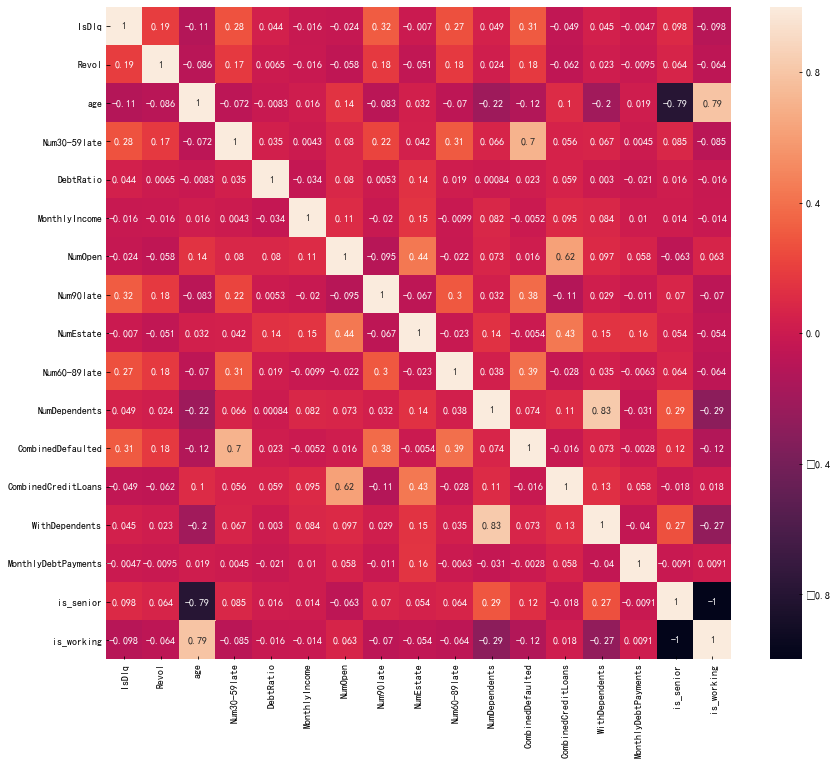

In [315]:
# 相关性分析
corr = data_train.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2g")

In [316]:
data_train.columns

Index(['IsDlq', 'Revol', 'age', 'Num30-59late', 'DebtRatio', 'MonthlyIncome',
       'NumOpen', 'Num90late', 'NumEstate', 'Num60-89late', 'NumDependents',
       'CombinedDefaulted', 'CombinedCreditLoans', 'WithDependents',
       'MonthlyDebtPayments', 'is_senior', 'is_working'],
      dtype='object')

In [317]:
# 特征分箱处理
def bin_woe(tar, var, n=None, cat=None):
    """
    连续自变量分箱,woe,iv变换
    @tar:target目标变量（0,1）
    @var:variable自变量进行woe,iv转换
    @n:分组数量
    """
    total_bad = tar.sum()
    total_good =tar.count()-total_bad
    totalRate = total_good/total_bad
    
    if cat == 's':
        msheet = pd.DataFrame({tar.name:tar,var.name:var,'var_bins':pd.qcut(var, n, duplicates='drop')})
        grouped = msheet.groupby(['var_bins'])
    elif (cat == 'd') and (n is None):
        msheet = pd.DataFrame({tar.name:tar,var.name:var})
        grouped = msheet.groupby([var.name])
        
    groupBad = grouped.sum()[tar.name]
    groupTotal = grouped.count()[tar.name]
    groupGood = groupTotal - groupBad
    groupRate = groupGood/groupBad
    groupBadRate = groupBad/groupTotal
    groupGoodRate = groupGood/groupTotal

    woe = np.log(groupRate/totalRate)
#     print(woe)
    iv = np.sum((groupGood/total_good-groupBad/total_bad)*woe)
    
    if cat == 's':
        new_var, cut = pd.qcut(var, n, duplicates='drop',retbins=True, labels=woe.tolist())
    elif cat == 'd':
        dictmap = {}
        for x in woe.index:
            dictmap[x] = woe[x]
        new_var, cut = var.map(dictmap), woe.index
    
    return woe.tolist(), iv, cut, new_var

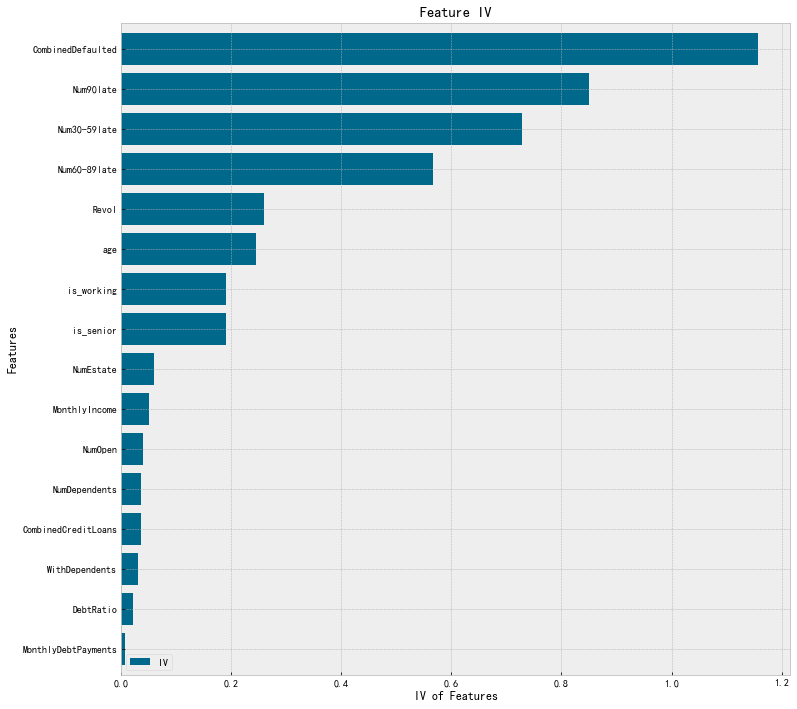

In [318]:
# 确定变量类型，连续变量还是离散变量
# dvar = ['Revol','DebtRatio','Num30-59late','CombinedDefaulted','WithDependents',
#         'NumEstate','NumDependents','CombinedCreditLoans','is_senior','is_working']
# svar = ['MonthlyIncome','age','NumOpen','MonthlyDebtPayments']

dvar = ['Revol','DebtRatio','Num30-59late', 'Num60-89late','Num90late','CombinedDefaulted','WithDependents',
        'NumEstate','NumDependents','CombinedCreditLoans','is_senior','is_working']
svar = ['MonthlyIncome','age','NumOpen','MonthlyDebtPayments']

# 可视化woe得分和iv得分
def woe_vs(data):
    cutdict = {}
    ivdict = {}
    woe_dict = {}
    woe_var = pd.DataFrame()
    for var in data.columns:
        if var in dvar:
            woe, iv, cut, new = bin_woe(data['IsDlq'], data[var], cat='d')
            woe_dict[var] = woe
            woe_var[var] = new
            ivdict[var] = iv
            cutdict[var] = cut
        elif var in svar:
            woe, iv, cut, new = bin_woe(data['IsDlq'], data[var], n=5, cat='s')
            woe_dict[var] = woe
            woe_var[var] = new
            ivdict[var] = iv
            cutdict[var] = cut
            
#     print(ivdict)
    ivdict = sorted(ivdict.items(), key=lambda x:x[1], reverse=False)
    iv_vs = pd.DataFrame([x[1] for x in ivdict],index=[x[0] for x in ivdict],columns=['IV'])
    ax = iv_vs.plot(kind='barh',
                    figsize=(12,12),
                    title='Feature IV',
                    fontsize=10,
                    width=0.8,
                    color='#00688B')
    ax.set_ylabel('Features')
    ax.set_xlabel('IV of Features')
    
    return ivdict, woe_var, woe_dict, cutdict

# woe转化
ivinfo, woe_data, woe_dict, cut_dict = woe_vs(data_train)

通过以上可以看出各个特征值之间的IV比较情况。其中，DebtRatio，MonthlyIncome，NumOpen，NumEstate，NumDependents等5个特征的IV值小于0.1，属于预测能力较弱的变量。

### 选择变量

根据上面相关性分析，看到一些特征之间相关性很强（相关系数>0.7）。因此，筛选规则是：**在特征相关性高的变量中，选择IV值高的。**
- **is_senior | is_working | age**：选择age
- **WithDependents | NumDependents**：选择NumDependents
- **CombinedDefaulted | Num30-59late**：选择CombinedDefaulted
- **NumOpen | CombinedCreditLoans**：选择NumOpen



In [321]:
# IV<0.1，去掉 | 不去掉 两组
ivinfo_keep = ['Revol', 'age', 'DebtRatio', 'MonthlyIncome',
               'NumOpen', 'Num90late', 'NumEstate', 'Num60-89late', 'NumDependents',
               'CombinedDefaulted','MonthlyDebtPayments']
ivinfo_remove = ['Revol', 'age', 'Num90late', 'Num60-89late', 'CombinedDefaulted']

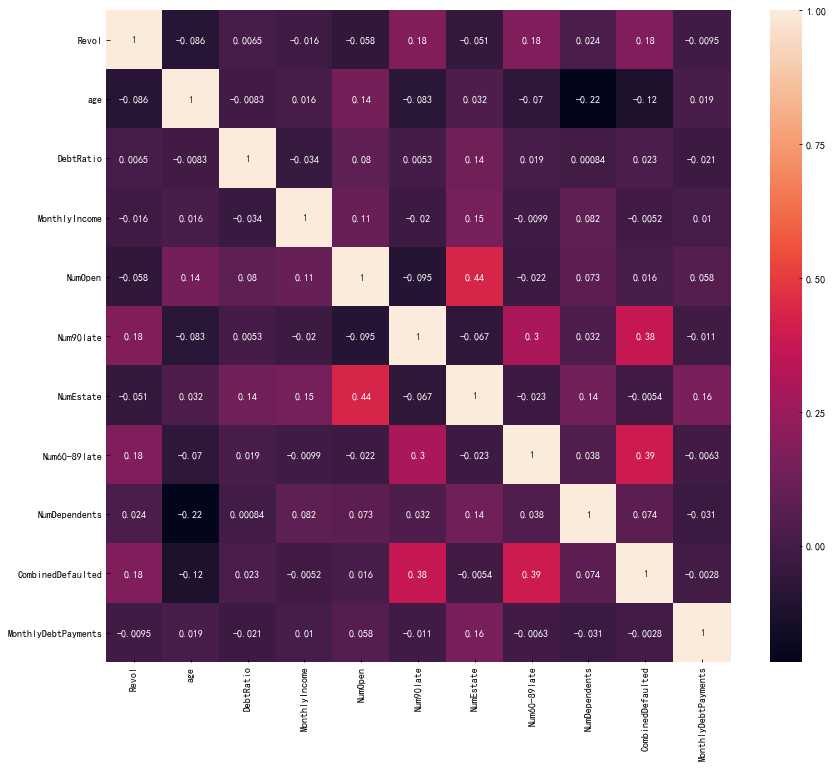

In [322]:
# 再次检验相关性分析
corr = data_train[ivinfo_keep].corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2g")

通过以上看到：各变量之间的相关性非常小，可以初始的判断没有多重共线性的问题。

In [323]:
X = woe_data[ivinfo_keep]
y = Ytrain

In [324]:
# 通过方差膨胀因子vif进一步判断是否存在多重共线性
# def vif_test():

In [325]:
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=42)
logit = LogisticRegression(random_state=0,
                           solver="sag",
                           penalty="l2",
                           class_weight="balanced",
                           C=1.0,
                           max_iter=500)

# scaler = StandardScaler().fit(X_train)

In [326]:
# X_train_scaled = scaler.transform(X_train) #scaling features!
# X_val_scaled = scaler.transform(X_val)

In [327]:
logit.fit(X_train, y_train)
logit_scores_proba = logit.predict_proba(X_train)
logit_scores = logit_scores_proba[:,1]

In [328]:
# roc评估曲线
def plot_roc_curve(fpr, tpr, auc_score, label=None):
    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, linewidth=2, label='AUC = %0.2f'%auc_score)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")
    plt.legend()

AUC Score 0.8295231452864655


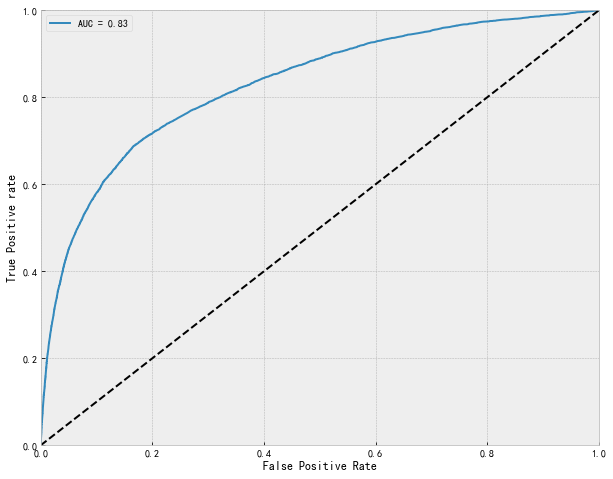

In [329]:
fpr_logit, tpr_logit, thresh_logit = roc_curve(y_train, logit_scores)
auc_score = roc_auc_score(y_train, logit_scores)
print("AUC Score {}".format(auc_score))
plot_roc_curve(fpr_logit,tpr_logit, auc_score)

AUC Score 0.8226335286756636


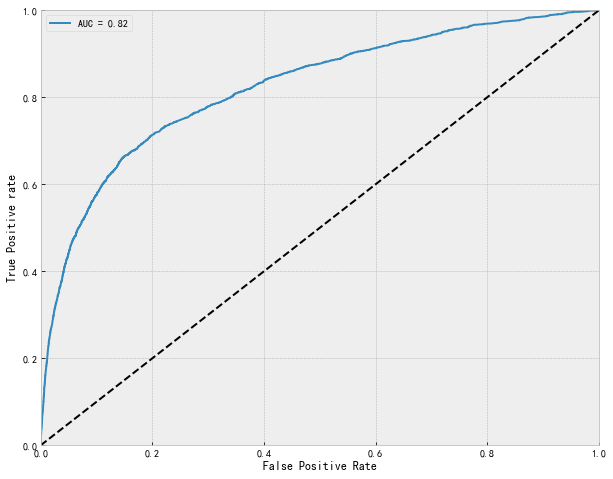

In [330]:
logit_scores_proba_val = logit.predict_proba(X_val)
logit_scores_val = logit_scores_proba_val[:,1]
fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(y_val, logit_scores_val)
auc_score_val = roc_auc_score(y_val, logit_scores_val)
plot_roc_curve(fpr_logit_val,tpr_logit_val, auc_score_val)
print("AUC Score {}".format(roc_auc_score(y_val,logit_scores_val)))

In [331]:
coe = logit.coef_
intercept = logit.intercept_

In [332]:
# 制作评分卡表格

B = 20 / math.log(2)
A = 600 + B / math.log(20)
# # 基础分
base = round(A-B * intercept[0], 0)

featurelist = []
woelist = []
coelist = []
cutlist = []
for k,v in woe_dict.items():
    if k in ivinfo_keep:
        for n in range(0,len(v)):
            featurelist.append(k)
            woelist.append(v[n])
            coelist.append(coe[0][n])
            cutlist.append(cut_dict[k][n])
            
scoreboard = pd.DataFrame({'feature':featurelist, 'woe':woelist, 'coe':coelist, 'cut':cutlist},
                          columns=['feature','cut','woe','coe'])
scoreboard['score'] = round(-scoreboard['woe']*scoreboard['coe']*B,0).astype('int64')

In [333]:
scoreboard.style.background_gradient('autumn')

,feature,cut,woe,coe,score
0,Revol,0,0.119347,-0.573387,2
1,Revol,1,-2.22722,-0.721794,-46
2,age,21,-0.487176,-0.573387,-8
3,age,39,-0.25255,-0.721794,-5
4,age,48,-0.078322,-1.16701,-3
5,age,56,0.430131,-0.375617,5
6,age,65,1.05418,-0.231728,7
7,DebtRatio,0,0.0300524,-0.573387,0
8,DebtRatio,1,-0.749988,-0.721794,-16
9,MonthlyIncome,0,-0.032377,-0.573387,-1
